In [55]:
# Libraries
import torch
import casadi as ca
import pandas as pd
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

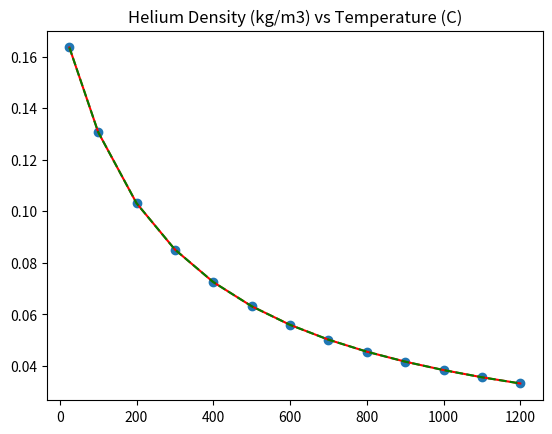

[ 4.88005940e+01  2.73401023e+02 -2.15391902e-05]


In [56]:
# he properties
Mw_he = 4.0026 # kg/kmol
data_path = os.path.join("..", "data", "He_property.csv")
df_he = pd.read_csv(data_path)


def rho_he_fit(T, a, b, c):
    return a / (T + b) + c
prho, _ = curve_fit(rho_he_fit, df_he['T [C]'], df_he['rho [kg/m3]'])
def rho_he(T):
    return prho[0] / (T + prho[1]) + prho[2]
plt.scatter(df_he['T [C]'], df_he['rho [kg/m3]'])
plt.plot(df_he['T [C]'], rho_he_fit(df_he['T [C]'], *prho), 'r-')
plt.plot(df_he['T [C]'], rho_he(df_he['T [C]']), 'g--')
plt.title('Helium Density (kg/m3) vs Temperature (C)')
plt.show()
print(prho)

Cp_he = 20.786 # J/mol*K

In [57]:
# Geometry
OD = torch.tensor(6.33e-3) # m
ID = torch.tensor(5.03e-3) # m
L = torch.tensor(430e-3) #m

## Radii
ri = ID/2
ro = OD/2

## Wall thickness
tkn = ro - ri

## Cross-sectional areas
Ai = torch.pi * ri**2 # m2
Ao = torch.pi * ro**2 # m2
Aw = Ao - Ai # m2

## Perimeters
pri = torch.pi * ID # m
pro = torch.pi * OD # m

## Surface areas
Si = pri * L # m2
So = pro * L # m2

## Volume
Vi = Ai * L # m3
Vw = Aw * L # m3

In [58]:
# Mesh
dz = torch.tensor(1e-3) # m
n_nodes = int(torch.ceil(L / dz) + 1)
z = torch.linspace(0, L, n_nodes)

In [59]:
# Feed conditions
Fv_sccm = torch.tensor(50.0) # sccm: mL/min
Fi = Fv_sccm * 1e-6 / 60 * rho_he(0) / Mw_he * 1e3 # mol/s
P = 1.01325 # bar

In [60]:
# Continuity equation - Non-isothermal Steady State 1D FDM
# State variables: F (mol/s), Vz (m/s), T (K)

# Convert geometry to CasADi
dz_ca = float(dz)
n_nodes_ca = int(n_nodes)
L_ca = float(L)
ri_ca = float(ri)
Ai_ca = float(Ai)
Si_ca = float(Si)
pri_ca = float(pri)

# Heat flux from inner wall (W/m)
dP_dz = 1  # W/m

# Helium properties (need to fit for CasADi)
Mw_he_ca = 4.0026  # kg/kmol
R = 8.314  # J/(mol*K)
P_ca = P * 1e5  # Pa (convert from bar)

# Define CasADi symbolic variables for all nodes
F = ca.MX.sym('F', n_nodes_ca)  # mol/s
Vz = ca.MX.sym('Vz', n_nodes_ca)  # m/s
T = ca.MX.sym('T', n_nodes_ca)  # K (will use Celsius in equations)

# Stack all variables
x = ca.vertcat(F, Vz, T)

# Create residual equations
res = []

# Boundary conditions (inlet)
T_inlet_C = 25  # °C
T_inlet_K = T_inlet_C + 273.15  # K
res.append(F[0] - float(Fi))
res.append(T[0] - T_inlet_K)  # Convert to K

# For each internal node
for i in range(1, n_nodes_ca):
    # Temperature in Celsius for property evaluation
    T_C_im1 = T[i-1] - 273.15  # Previous node in Celsius
    T_C_i = T[i] - 273.15      # Current node in Celsius
    T_avg_C = (T_C_im1 + T_C_i) / 2
    
    # Helium properties at average temperature
    rho_avg = prho[0] / (T_avg_C + prho[1]) + prho[2]  # kg/m3
    Cp_avg = Cp_he  # J/(mol*K)
    
    # 1. Mass continuity: dF/dz = 0 (no reaction)
    dF_dz = (F[i] - F[i-1]) / dz_ca
    res.append(dF_dz)
    
    # 2. Momentum equation: F = C * Ai * Vz
    # where C = n/V (molar concentration, mol/m3)
    # Using ideal gas: C = P/(R*T)
    C_ideal = P_ca / (R * T[i])  # mol/m3
    res.append(F[i] - C_ideal * Ai_ca * Vz[i])
    
    # 3. Energy equation: F*Cp*dT/dz = Q_in
    # Heat input per unit length from wall
    Q_in = dP_dz * pri_ca  # W/m
    
    dT_dz = (T[i] - T[i-1]) / dz_ca
    energy_balance = F[i] * Cp_avg * dT_dz - Q_in
    res.append(energy_balance)

# Additional constraint at inlet for Vz
# Using ideal gas: C = P/(R*T), so Vz = F / (C * Ai)
C_inlet = P_ca / (R * T_inlet_K)  # mol/m3
Vz_inlet = float(Fi) / (C_inlet * Ai_ca)
res.append(Vz[0] - Vz_inlet)

# Stack all residuals
res = ca.vertcat(*res)

print(f"Number of equations: {res.shape[0]}")
print(f"Number of variables: {x.shape[0]}")
print(f"System is {'determined' if res.shape[0] == x.shape[0] else 'over/under-determined'}")
print(f"\nInlet velocity check: {Vz_inlet*1000:.2f} mm/s")
print(f"Expected from volumetric flow: {float(Fv_sccm*1e-6/60/Ai_ca*1000):.2f} mm/s (at STP)")


Number of equations: 1293
Number of variables: 1293
System is determined

Inlet velocity check: 45.75 mm/s
Expected from volumetric flow: 41.94 mm/s (at STP)


Total number of variables............................:     1293
                     variables with only lower bounds:      862
                variables with lower and upper bounds:      431
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1293
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   2.0719415064485482e-25    2.0719415064485482e-25
Dual infeasibility......:   1.4346413748966574e-24    1.4346413748966574e-24
Constraint violation....:   2.2003232569289821e-14    2.2003232569289821e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

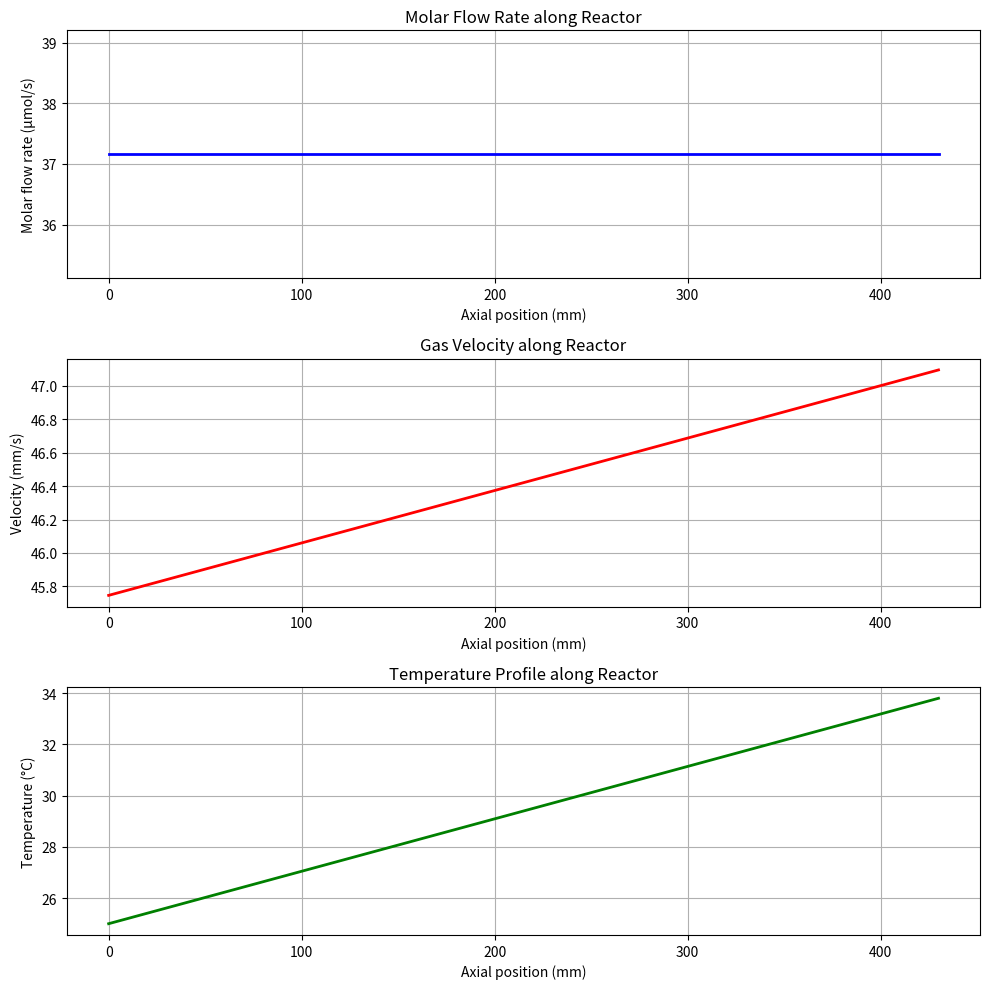


SIMULATION RESULTS
Inlet conditions:
  F_in  = 37.158 μmol/s
  Vz_in = 45.746 mm/s
  T_in  = 25.00 °C

Outlet conditions:
  F_out  = 37.158 μmol/s
  Vz_out = 47.096 mm/s
  T_out  = 33.80 °C

Temperature rise: 8.80 °C
Total heat input: 430.000 mW


In [61]:
# Solve the system using CasADi NLP solver
# Initial guess
F_init = float(Fi) * ca.DM.ones(n_nodes_ca)
Vz_init = Vz_inlet * ca.DM.ones(n_nodes_ca)
T_init = (T_inlet_C + 273.15) * ca.DM.ones(n_nodes_ca)
x0 = ca.vertcat(F_init, Vz_init, T_init)

# Create NLP problem
nlp = {
    'x': x,
    'f': ca.dot(res, res),  # Minimize squared residuals
    'g': res
}

# Solver options
opts = {
    'ipopt.print_level': 3,
    'ipopt.max_iter': 500,
    'ipopt.tol': 1e-8,
    'print_time': False
}

# Create solver
solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

# Set bounds (all variables are unbounded except for physical constraints)
lbx = [-ca.inf] * x.shape[0]
ubx = [ca.inf] * x.shape[0]

# Temperature bounds (reasonable physical range)
for i in range(2*n_nodes_ca, 3*n_nodes_ca):
    lbx[i] = 273.15  # 0°C minimum
    ubx[i] = 1500    # 1227°C maximum

# Positive flow rate and velocity
for i in range(n_nodes_ca):
    lbx[i] = 0  # F >= 0
    lbx[n_nodes_ca + i] = 0  # Vz >= 0

# Solve
sol = solver(x0=x0, lbx=lbx, ubx=ubx, lbg=0, ubg=0)

# Extract solution
x_sol = sol['x'].full().flatten()
F_sol = x_sol[:n_nodes_ca]
Vz_sol = x_sol[n_nodes_ca:2*n_nodes_ca]
T_sol = x_sol[2*n_nodes_ca:3*n_nodes_ca]

# Convert to numpy arrays for plotting
z_np = z.numpy()
F_sol_np = F_sol
Vz_sol_np = Vz_sol
T_sol_np = T_sol - 273.15  # Convert to Celsius

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Molar flow rate
axes[0].plot(z_np * 1000, F_sol_np * 1e6, 'b-', linewidth=2)
axes[0].set_xlabel('Axial position (mm)')
axes[0].set_ylabel('Molar flow rate (μmol/s)')
axes[0].set_title('Molar Flow Rate along Reactor')
axes[0].grid(True)

# Velocity
axes[1].plot(z_np * 1000, Vz_sol_np * 1000, 'r-', linewidth=2)
axes[1].set_xlabel('Axial position (mm)')
axes[1].set_ylabel('Velocity (mm/s)')
axes[1].set_title('Gas Velocity along Reactor')
axes[1].grid(True)

# Temperature
axes[2].plot(z_np * 1000, T_sol_np, 'g-', linewidth=2)
axes[2].set_xlabel('Axial position (mm)')
axes[2].set_ylabel('Temperature (°C)')
axes[2].set_title('Temperature Profile along Reactor')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("SIMULATION RESULTS")
print("="*60)
print(f"Inlet conditions:")
print(f"  F_in  = {F_sol_np[0]*1e6:.3f} μmol/s")
print(f"  Vz_in = {Vz_sol_np[0]*1000:.3f} mm/s")
print(f"  T_in  = {T_sol_np[0]:.2f} °C")
print(f"\nOutlet conditions:")
print(f"  F_out  = {F_sol_np[-1]*1e6:.3f} μmol/s")
print(f"  Vz_out = {Vz_sol_np[-1]*1000:.3f} mm/s")
print(f"  T_out  = {T_sol_np[-1]:.2f} °C")
print(f"\nTemperature rise: {T_sol_np[-1] - T_sol_np[0]:.2f} °C")
print(f"Total heat input: {dP_dz * L_ca * 1e3:.3f} mW")
print("="*60)
